In [16]:
import gym 
from custom_envs.windy_gridworld import WindyGridworldEnv
import numpy as np
from tqdm import tqdm
import time
from sklearn.tree import DecisionTreeRegressor
from function_approximators.replay import ReplayBuffer
import torch

from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from copy import deepcopy

# env = WindyGridworldEnv()
env = gym.make("CartPole-v1")

In [67]:
def _predict(models, inputs):
    if len(models) > 1:
        out = []
        for i, f in enumerate(models[1:]):
            out.append(f.predict(inputs)*(i+1)/(len(models)-1))
        return np.mean(out, 0)
    else:
        return models[0].predict(inputs)

def act(env, models, s, epsilon, fitted, explore):
    if (explore and np.random.random_sample() < epsilon) or (not fitted):
        action = env.action_space.sample()
    else:       
        Q = [_predict(models, np.concatenate([s, actions[i]],-1).reshape(1,-1)) for i in range(env.action_space.n)]
        action = np.argmax(Q)
    return action

def _update(env, models, batch, gamma):
    inputs = np.concatenate([batch.states, [actions[int(i.item())] for i in batch.actions]], -1)
    preds = []

    for i in range(env.action_space.n):
        next_inputs = np.concatenate([batch.next_states, np.zeros((batch.actions.size()[0], 1)) + actions[i]], -1)
        # print(next_inputs.shape)
        preds.append(_predict(models, next_inputs))
    preds = np.array(preds).T
    # print(np.any(np.isnan(preds)))
    # print(np.all(np.isfinite(preds)))
    # print(preds)
    outputs = np.array(batch.rewards + gamma * (1-batch.done) * np.max(preds, 1).reshape(-1,1)).reshape(-1)
   
    model.fit(inputs, outputs)


def play_episode(env, models, replay_buffer, fitted, batch_size, gamma, epsilon, explore, train, episode_length):
    s = env.reset()
    done = False
    episode_timesteps = 0
    episode_return = 0

    while not done:
        a = act(env, models, s, epsilon, fitted, explore=explore)
        s_next, r, done, _ = env.step(a)
        if train:
            replay_buffer.push(
                np.array(s, dtype=np.float32),
                np.array([a], dtype=np.float32),
                np.array(s_next, dtype=np.float32),
                np.array([r], dtype=np.float32),
                np.array([done], dtype=np.float32),
                )
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                if not fitted:
                    inputs = np.concatenate([batch.states, [actions[int(i.item())] for i in batch.actions]], -1)
                    outputs = np.array(batch.rewards).reshape(-1)
                    model.fit(inputs, outputs)
                    # print(inputs.shape)
                    # print(outputs.shape)
                    fitted = True
                _update(env, models, batch, gamma)
       
        episode_timesteps += 1
        episode_return += r
        
        if episode_timesteps == episode_length:
            break
        s = s_next

    return episode_timesteps, episode_return, fitted


In [72]:
model = DecisionTreeRegressor(max_depth=10, min_samples_split=20, min_samples_leaf=10)
# model = SVR()
# model = LinearRegression()
# model = RandomForestRegressor(n_estimators=5, max_depth=5)
# model2 = RandomForestRegressor(n_estimators=5, max_depth=5)
# model = MLPRegressor(hidden_layer_sizes=(32,32))
replay_size = 10000
replay_buffer = ReplayBuffer(replay_size)
# actions = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
actions =  [[1,0],[0,1]]

In [73]:
max_timesteps = 20000
timesteps_elapsed = 0
episode_length = 200
eval_freq = 1000
eval_episodes = 5
gamma = 0.99
epsilon = 1
batch_size = 512
fitted = False

models = [model]

with tqdm(total=max_timesteps) as pbar:

    while timesteps_elapsed < max_timesteps:
        episode_timesteps, _, fitted = play_episode(env, models, replay_buffer, fitted=fitted, batch_size=batch_size, gamma=gamma, 
                                                    epsilon=epsilon, explore=True, train=True, episode_length=episode_length)
        
        timesteps_elapsed += episode_timesteps
        pbar.update(episode_timesteps)

        if timesteps_elapsed % eval_freq < episode_timesteps:
            models.append(deepcopy(model))
            eval_returns = 0
            for _ in range(eval_episodes):
                _ , episode_return, fitted = play_episode(env, models, replay_buffer, fitted=fitted, batch_size=batch_size, gamma=gamma, 
                                                  epsilon=epsilon, explore=False, train=False, episode_length=episode_length)
                eval_returns += episode_return / eval_episodes

            epsilon = max(epsilon*0.7,0.05)
            # tree.plot_tree(model)
            pbar.write(f"Evaluation at timestep {timesteps_elapsed} returned a mean returns of {eval_returns}")
            pbar.write(f"Epsilon = {epsilon}")


  5%|▌         | 1047/20000 [00:01<00:31, 603.79it/s] Evaluation at timestep 1011 returned a mean returns of 26.8
Epsilon = 0.7
 10%|█         | 2055/20000 [00:04<00:53, 334.20it/s]Evaluation at timestep 2018 returned a mean returns of 20.0
Epsilon = 0.48999999999999994
 15%|█▌        | 3033/20000 [00:07<01:00, 280.16it/s]Evaluation at timestep 3004 returned a mean returns of 24.6
Epsilon = 0.3429999999999999
 20%|██        | 4015/20000 [00:11<00:55, 290.04it/s]Evaluation at timestep 4015 returned a mean returns of 107.8
Epsilon = 0.24009999999999992
 25%|██▌       | 5041/20000 [00:15<00:56, 262.55it/s]Evaluation at timestep 5041 returned a mean returns of 106.79999999999998
Epsilon = 0.16806999999999994
 30%|███       | 6051/20000 [00:20<01:05, 214.06it/s]Evaluation at timestep 6051 returned a mean returns of 110.4
Epsilon = 0.11764899999999995
 35%|███▌      | 7084/20000 [00:25<00:57, 224.74it/s]Evaluation at timestep 7084 returned a mean returns of 108.80000000000001
Epsilon = 0.082

[Text(168.5755617977528, 206.56799999999998, 'X[2] <= 0.111\nmse = 0.313\nsamples = 512\nvalue = 7.166'),
 Text(60.188764044943824, 184.824, 'X[2] <= 0.098\nmse = 0.018\nsamples = 164\nvalue = 7.634'),
 Text(45.14157303370787, 163.07999999999998, 'X[1] <= 0.57\nmse = 0.003\nsamples = 140\nvalue = 7.679'),
 Text(37.61797752808989, 141.336, 'X[2] <= -0.01\nmse = 0.002\nsamples = 129\nvalue = 7.684'),
 Text(30.094382022471912, 119.592, 'mse = 0.004\nsamples = 10\nvalue = 7.621'),
 Text(45.14157303370787, 119.592, 'X[0] <= -0.035\nmse = 0.001\nsamples = 119\nvalue = 7.689'),
 Text(15.047191011235956, 97.848, 'X[1] <= -0.221\nmse = 0.003\nsamples = 43\nvalue = 7.671'),
 Text(7.523595505617978, 76.10399999999998, 'mse = 0.006\nsamples = 10\nvalue = 7.644'),
 Text(22.570786516853936, 76.10399999999998, 'X[2] <= 0.005\nmse = 0.001\nsamples = 33\nvalue = 7.68'),
 Text(15.047191011235956, 54.360000000000014, 'mse = 0.002\nsamples = 11\nvalue = 7.657'),
 Text(30.094382022471912, 54.36000000000001

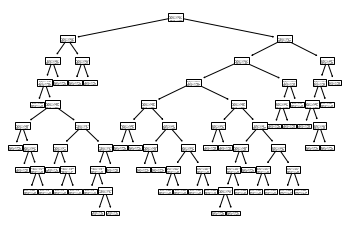

In [74]:
tree.plot_tree(model)


In [36]:
batch = replay_buffer.sample(8)
inputs = np.concatenate([batch.states, [actions[int(i.item())] for i in batch.actions]], -1)
preds = []
try:
    for i in range(env.action_space.n):
        next_inputs = np.concatenate([batch.next_states, np.zeros((batch.actions.size()[0], 1)) + actions[i]], -1)
        preds.append(model.predict(next_inputs))
    preds = np.array(preds).T
    outputs = np.array(batch.rewards + gamma * (1-batch.done) * np.max(preds, 1).reshape(-1,1)).reshape(-1)
except:
    # print("init")
    outputs = np.array(batch.rewards).reshape(-1)

In [37]:
model3 = DecisionTreeRegressor(max_depth=6, min_samples_split=20, min_samples_leaf=10)
model3.fit(inputs,outputs)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=10, min_samples_split=20)

In [54]:
np.any(np.isnan(outputs))
# np.all(np.isfinite(outputs))

False

In [39]:
models = [model, model1, model2]
preds = []
for i, f in enumerate(models):
    preds.append(f.predict(inputs)*(i+1)/len(models))


In [62]:
models[1:]

[SVR()]